# Linguagem, Bibliotecas e Pacotes

In [637]:
# Import libs

import numpy as np
import pandas as pd
import missingno as msno
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from keras import Sequential
from keras.layers import Dense
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf


# Leitura dos Dados

In [667]:
# Read NBA data from excel file

nba_data = pd.read_excel('nba_data.xlsx')

In [639]:
# Drop "Unnamed: 0" column

nba_data.drop(['Unnamed: 0'], axis=1, inplace=True)
nba_data.head()

,HOME_TEAM_ID,HOME_TEAM_ABBREVIATION,HOME_GAME_ID,HOME_MATCHUP,HOME_SEASON,HOME_GAME_N,HOME_WL,AWAY_TEAM_ID,AWAY_TEAM_ABBREVIATION,AWAY_GAME_ID,...,BLK_RANK_y,BLKA_RANK_y,PF_RANK_y,PFD_RANK_y,PTS_RANK_y,PLUS_MINUS_RANK_y,GAME_DATE_y,SEASON_y,GAME_N_y,COMPARE_y
0,1610612764,WAS,22200019,WAS vs. CHI,2022-23,2,W,1610612741,CHI,22200019,...,6,2,25,8,8,7,2022-10-19-2022_23,2022-23,2,2-1610612741-2022-23
1,1610612739,CLE,22200039,CLE vs. WAS,2022-23,3,W,1610612764,WAS,22200039,...,2,7,7,27,18,9,2022-10-21-2022_23,2022-23,3,3-1610612764-2022-23
2,1610612764,WAS,22200052,WAS vs. DET,2022-23,4,W,1610612765,DET,22200052,...,28,30,10,7,17,27,2022-10-22-2022_23,2022-23,4,4-1610612765-2022-23
3,1610612764,WAS,22200074,WAS vs. IND,2022-23,5,L,1610612754,IND,22200074,...,3,21,23,17,11,25,2022-10-26-2022_23,2022-23,6,6-1610612754-2022-23
4,1610612738,BOS,22200089,BOS vs. WAS,2022-23,6,W,1610612764,WAS,22200089,...,5,7,19,23,20,11,2022-10-28-2022_23,2022-23,6,6-1610612764-2022-23


# Análise Inicial

In [640]:
# Get nba_data dataframa shape

nba_data.shape

(6963, 132)

In [641]:
# Get nba_data dataframe columns

nba_data.columns

Index(['HOME_TEAM_ID', 'HOME_TEAM_ABBREVIATION', 'HOME_GAME_ID',
       'HOME_MATCHUP', 'HOME_SEASON', 'HOME_GAME_N', 'HOME_WL', 'AWAY_TEAM_ID',
       'AWAY_TEAM_ABBREVIATION', 'AWAY_GAME_ID',
       ...
       'BLK_RANK_y', 'BLKA_RANK_y', 'PF_RANK_y', 'PFD_RANK_y', 'PTS_RANK_y',
       'PLUS_MINUS_RANK_y', 'GAME_DATE_y', 'SEASON_y', 'GAME_N_y',
       'COMPARE_y'],
      dtype='object', length=132)

In [642]:
# Get nba_data dataframe describe

nba_data.describe()

,HOME_TEAM_ID,HOME_GAME_ID,HOME_GAME_N,AWAY_TEAM_ID,AWAY_GAME_ID,AWAY_GAME_N,TEAM_ID_x,GP_x,W_x,L_x,...,AST_RANK_y,TOV_RANK_y,STL_RANK_y,BLK_RANK_y,BLKA_RANK_y,PF_RANK_y,PFD_RANK_y,PTS_RANK_y,PLUS_MINUS_RANK_y,GAME_N_y
count,6.963000e+03,6.963000e+03,6963.000000,6.963000e+03,6.963000e+03,6963.000000,6.963000e+03,6963.000000,6963.000000,6963.000000,...,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000,6963.000000
mean,1.610613e+09,2.195075e+07,40.421657,1.610613e+09,2.195075e+07,40.431567,1.610613e+09,39.421657,19.688640,19.733017,...,15.345541,15.321844,15.419647,15.286514,15.244004,15.371248,15.439466,15.327876,15.286227,40.431567
std,8.653343e+00,1.743568e+05,22.634354,8.640874e+00,1.743568e+05,22.614953,8.653343e+00,22.634354,13.039842,13.080083,...,8.664255,8.648501,8.662756,8.643116,8.639085,8.656732,8.616650,8.637555,8.633215,22.614953
min,1.610613e+09,2.170002e+07,2.000000,1.610613e+09,2.170002e+07,2.000000,1.610613e+09,1.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,1.610613e+09,2.180054e+07,21.000000,1.610613e+09,2.180054e+07,21.000000,1.610613e+09,20.000000,9.000000,9.000000,...,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,21.000000
50%,1.610613e+09,2.200003e+07,40.000000,1.610613e+09,2.200003e+07,40.000000,1.610613e+09,39.000000,18.000000,18.000000,...,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,16.000000,15.000000,15.000000,40.000000
75%,1.610613e+09,2.210070e+07,60.000000,1.610613e+09,2.210070e+07,60.000000,1.610613e+09,59.000000,29.000000,29.000000,...,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,60.000000
max,1.610613e+09,2.220123e+07,82.000000,1.610613e+09,2.220123e+07,82.000000,1.610613e+09,81.000000,64.000000,64.000000,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,82.000000


In [643]:
# Get classes

nba_data['HOME_WL'].value_counts()

HOME_WL
W    3936
L    3027
Name: count, dtype: int64

In [644]:
# Get nba_data dataframe info

nba_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6963 entries, 0 to 6962
Columns: 132 entries, HOME_TEAM_ID to COMPARE_y
dtypes: float64(46), int64(68), object(18)
memory usage: 7.0+ MB


# Chegagem de valores nulos

<Axes: >

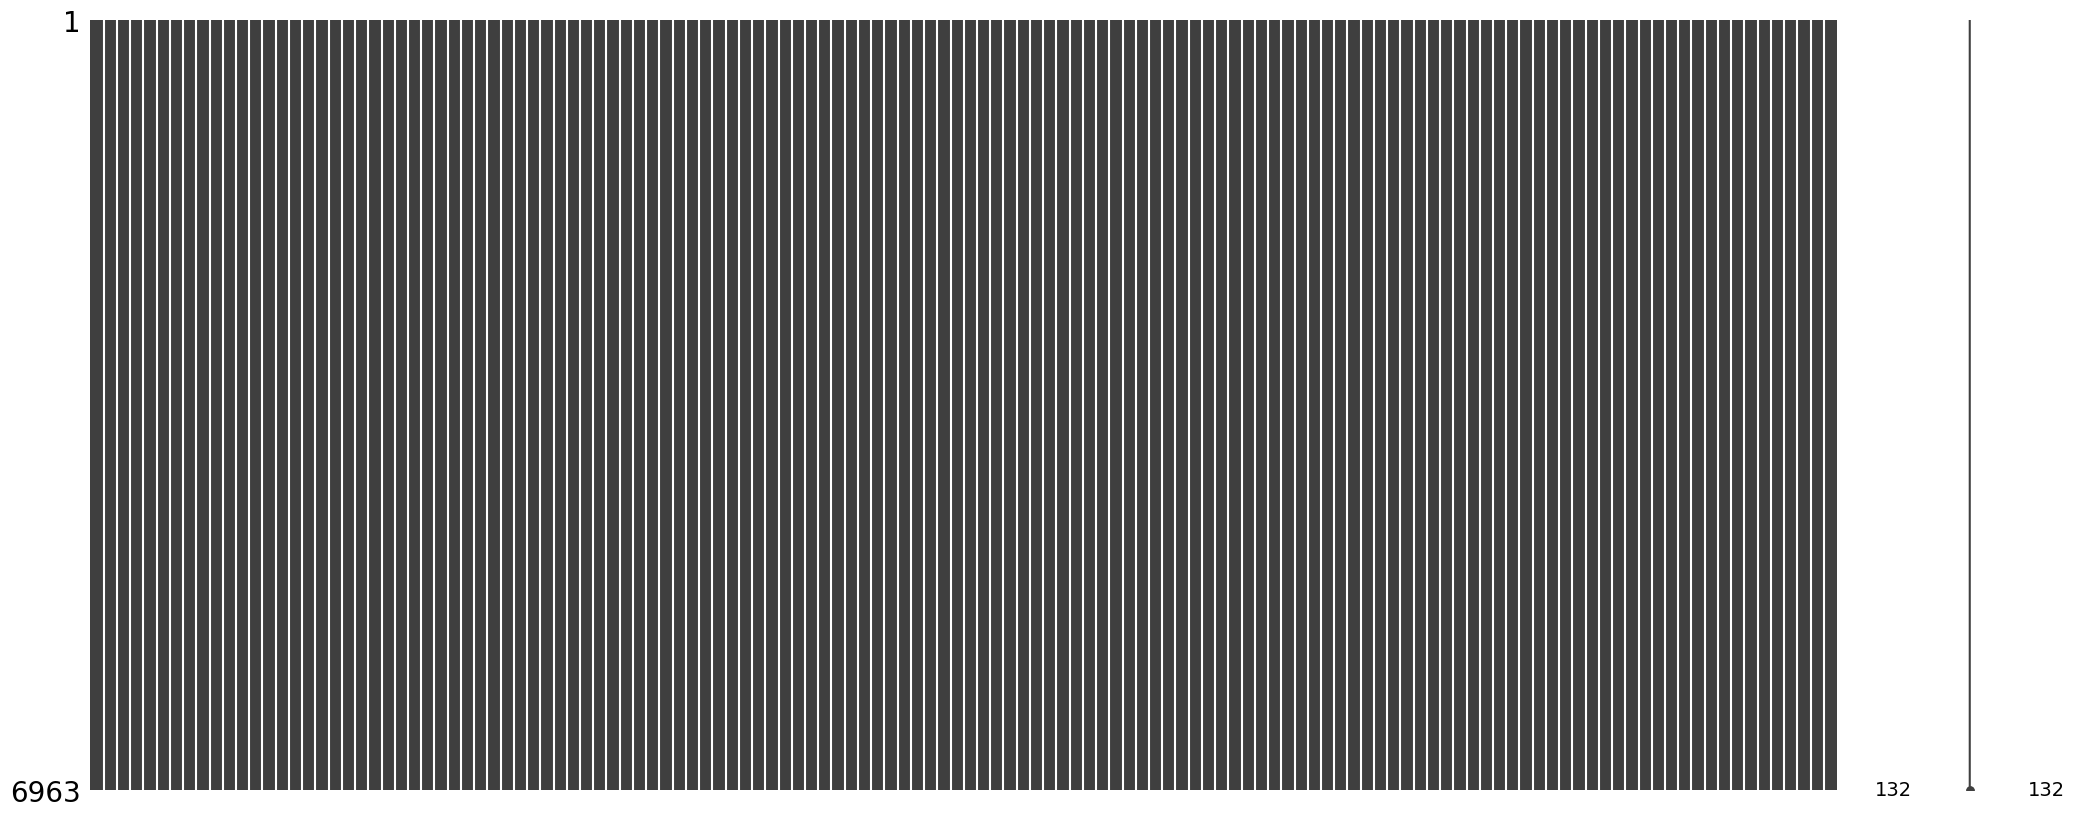

In [645]:
msno.matrix(nba_data)

# Relatório Pandas Profile

    Foi gerado o 'Pandas Profile Report' que oferece uma análise extensa do conjunto de dados que está sendo abordado.

In [10]:
# Generate and export as a .html file the Pandas Profile Report of the nba_shots dataframe

profile_data = ProfileReport(nba_data, title ='nba_data')
profile_data.to_file("nba_data_pandas_profile_report.html")

Summarize dataset:  95%|█████████▍| 106/112 [00:02<00:00, 37.38it/s, Calculate auto correlation]         


KeyboardInterrupt: 

In [ ]:
# Show Profile Report in this notebook

profile_data.to_notebook_iframe()

# Análise Exploratória


In [647]:
# Number of games per season

nba_data['HOME_SEASON'].value_counts()

HOME_SEASON
2022-23    1214
2021-22    1214
2018-19    1214
2017-18    1214
2020-21    1064
2019-20    1043
Name: count, dtype: int64

In [648]:
nba_data[nba_data['HOME_SEASON'] == '2022-23']['HOME_WL']

0       W
1       W
2       W
3       L
4       W
       ..
6905    W
6941    W
6942    W
6943    W
6944    L
Name: HOME_WL, Length: 1214, dtype: object

In [649]:
nba_data[(nba_data['HOME_TEAM_ABBREVIATION'] == 'WAS') & (nba_data['HOME_SEASON'] == '2022-23')]['HOME_WL']

0     W
2     W
3     L
5     L
7     L
10    W
11    W
12    W
13    L
14    W
15    W
19    W
22    L
25    L
26    L
33    W
34    W
39    L
40    W
41    L
42    L
44    W
49    L
51    L
52    W
53    W
57    L
60    W
61    L
62    L
64    L
65    L
67    W
69    L
71    L
72    W
74    W
75    L
77    L
79    W
80    L
Name: HOME_WL, dtype: object

In [650]:
nba_data[nba_data['HOME_WL'] == 'W']['HOME_TEAM_ABBREVIATION'].value_counts().index

Index(['DEN', 'MIL', 'PHI', 'BOS', 'UTA', 'TOR', 'GSW', 'MIA', 'LAC', 'MEM',
       'POR', 'LAL', 'DAL', 'BKN', 'IND', 'SAS', 'HOU', 'NOP', 'OKC', 'PHX',
       'MIN', 'ATL', 'CLE', 'WAS', 'SAC', 'CHA', 'CHI', 'NYK', 'ORL', 'DET'],
      dtype='object', name='HOME_TEAM_ABBREVIATION')

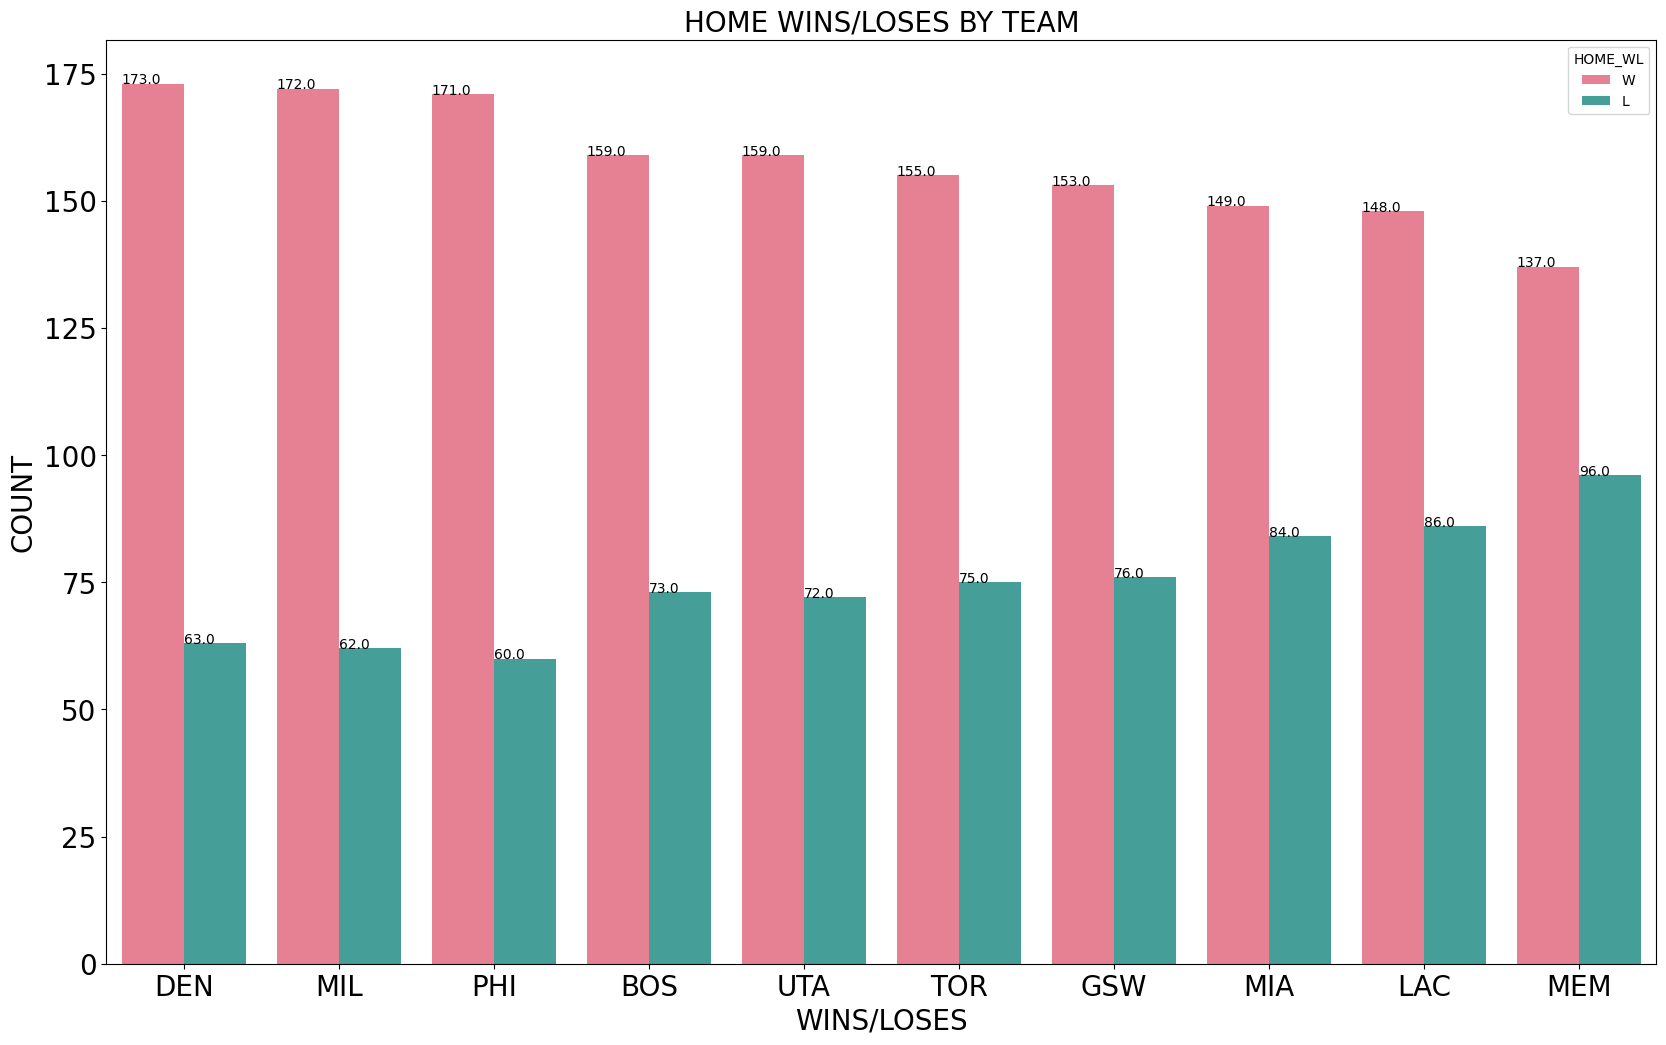

In [727]:
# TEAMS PER HOME WINS/LOSSES BAR PLOT

plt.figure(figsize=(20,12))
fig11 = sns.countplot(data=nba_data, x=nba_data['HOME_TEAM_ABBREVIATION'],
                        palette = 'husl', 
                        hue = nba_data['HOME_WL'],
                        order=nba_data[nba_data['HOME_WL'] == 'W']['HOME_TEAM_ABBREVIATION'].value_counts().iloc[:10].index
                        )
fig11.set_xlabel('WINS/LOSES', fontsize=20)
fig11.set_ylabel('COUNT', fontsize=20)
fig11.tick_params(labelsize=20)
plt.title('HOME WINS/LOSES BY TEAM', fontsize = 20)
for p in fig11.patches:
    txt = str(p.get_height().round(2))
    txt_x = p.get_x() 
    txt_y = p.get_height()
    fig11.text(txt_x,txt_y,txt)
plt.show()

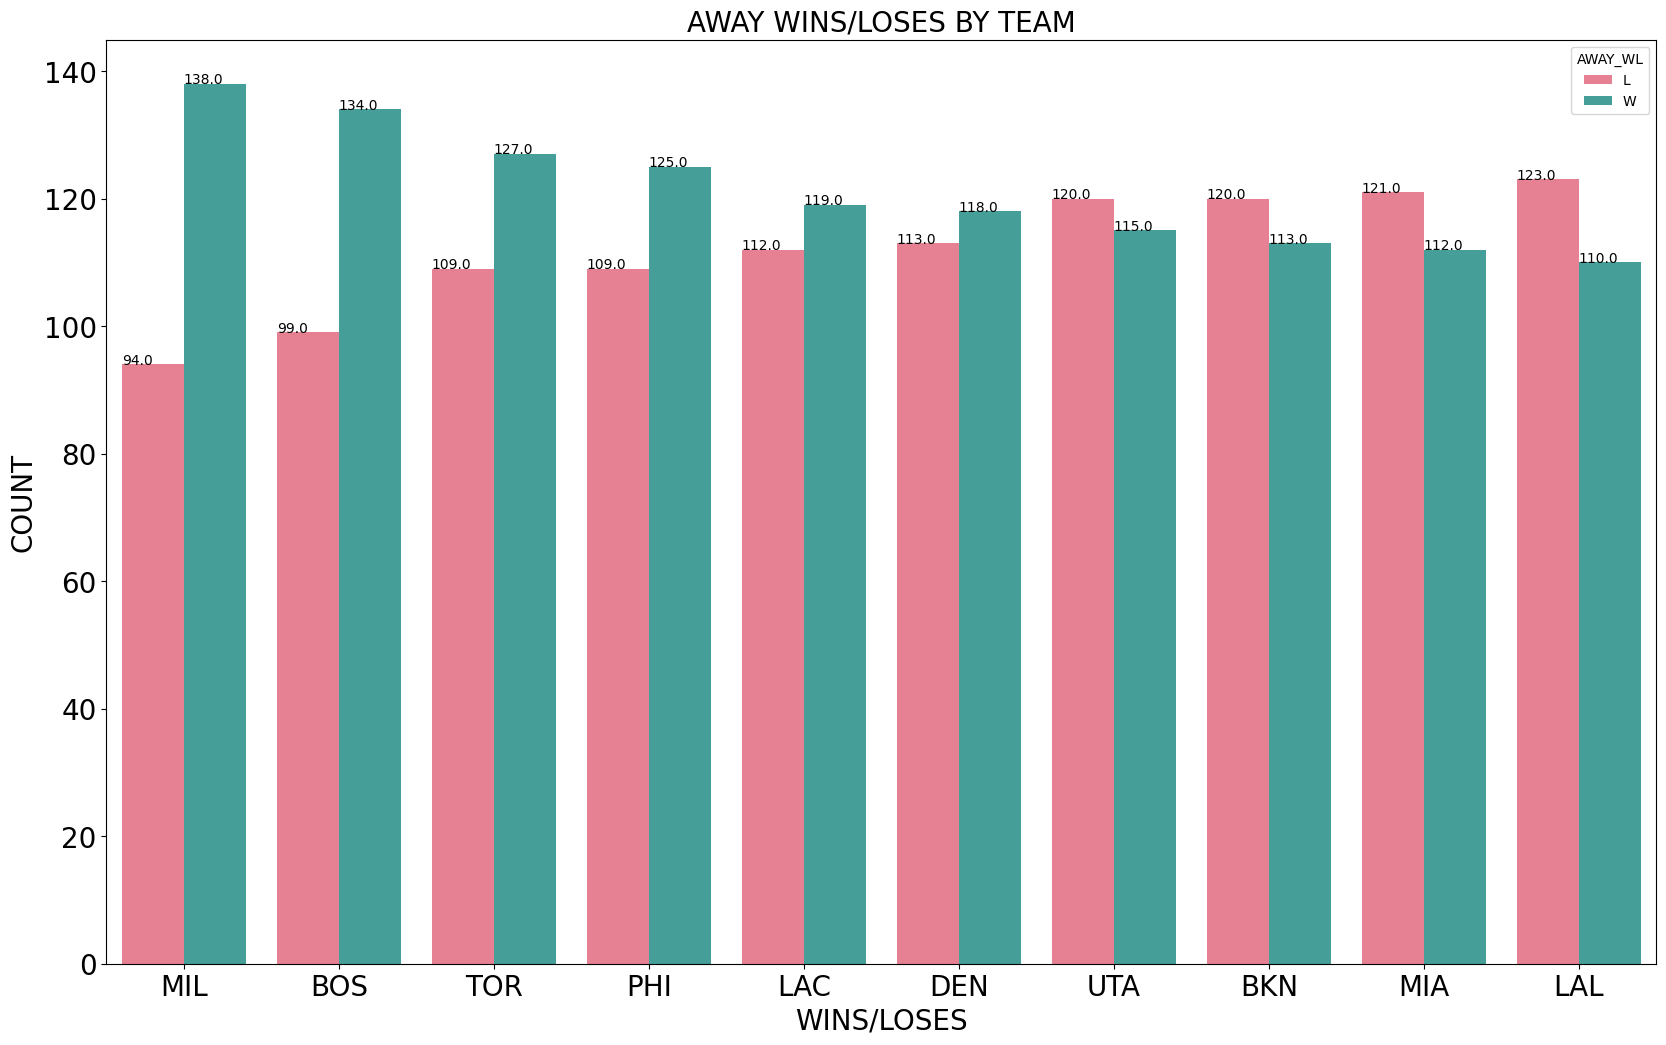

In [729]:
# TEAMS PER AWAY WINS/LOSSES BAR PLOT

plt.figure(figsize=(20,12))
fig2 = sns.countplot(data=nba_data, x=nba_data['AWAY_TEAM_ABBREVIATION'],
                        palette = 'husl', 
                        hue = nba_data['AWAY_WL'],
                        order=nba_data[nba_data['AWAY_WL'] == 'W']['AWAY_TEAM_ABBREVIATION'].value_counts().iloc[:10].index
                        )
fig2.set_xlabel('WINS/LOSES', fontsize=20)
fig2.set_ylabel('COUNT', fontsize=20)
fig2.tick_params(labelsize=20)
plt.title('AWAY WINS/LOSES BY TEAM', fontsize = 20)
for p in fig2.patches:
    txt = str(p.get_height().round(2))
    txt_x = p.get_x() 
    txt_y = p.get_height()
    fig2.text(txt_x,txt_y,txt)
plt.show()

In [694]:
den_home_data = nba_data[nba_data['HOME_TEAM_ABBREVIATION'] == 'DEN']
den_home_data.head()

,Unnamed: 0,HOME_TEAM_ID,HOME_TEAM_ABBREVIATION,HOME_GAME_ID,HOME_MATCHUP,HOME_SEASON,HOME_GAME_N,HOME_WL,AWAY_TEAM_ID,AWAY_TEAM_ABBREVIATION,...,BLK_RANK_y,BLKA_RANK_y,PF_RANK_y,PFD_RANK_y,PTS_RANK_y,PLUS_MINUS_RANK_y,GAME_DATE_y,SEASON_y,GAME_N_y,COMPARE_y
27,27,1610612743,DEN,22200422,DEN vs. WAS,2022-23,27,W,1610612764,WAS,...,5,12,7,25,23,25,2022-12-12-2022_23,2022-23,29,29-1610612764-2022-23
107,107,1610612743,DEN,22100411,DEN vs. WAS,2021-22,27,W,1610612764,WAS,...,11,8,8,6,23,22,2021-12-11-2021_22,2021-22,28,28-1610612764-2021-22
190,190,1610612743,DEN,22000502,DEN vs. WAS,2020-21,32,L,1610612764,WAS,...,30,11,30,1,9,25,2021-02-23-2020_21,2020-21,30,30-1610612764-2020-21
246,246,1610612743,DEN,21900252,DEN vs. WAS,2019-20,16,W,1610612764,WAS,...,24,23,17,28,2,16,2019-11-24-2019_20,2019-20,15,15-1610612764-2019-20
380,380,1610612743,DEN,21801148,DEN vs. WAS,2018-19,76,L,1610612764,WAS,...,24,8,14,12,7,25,2019-03-29-2018_19,2018-19,78,78-1610612764-2018-19


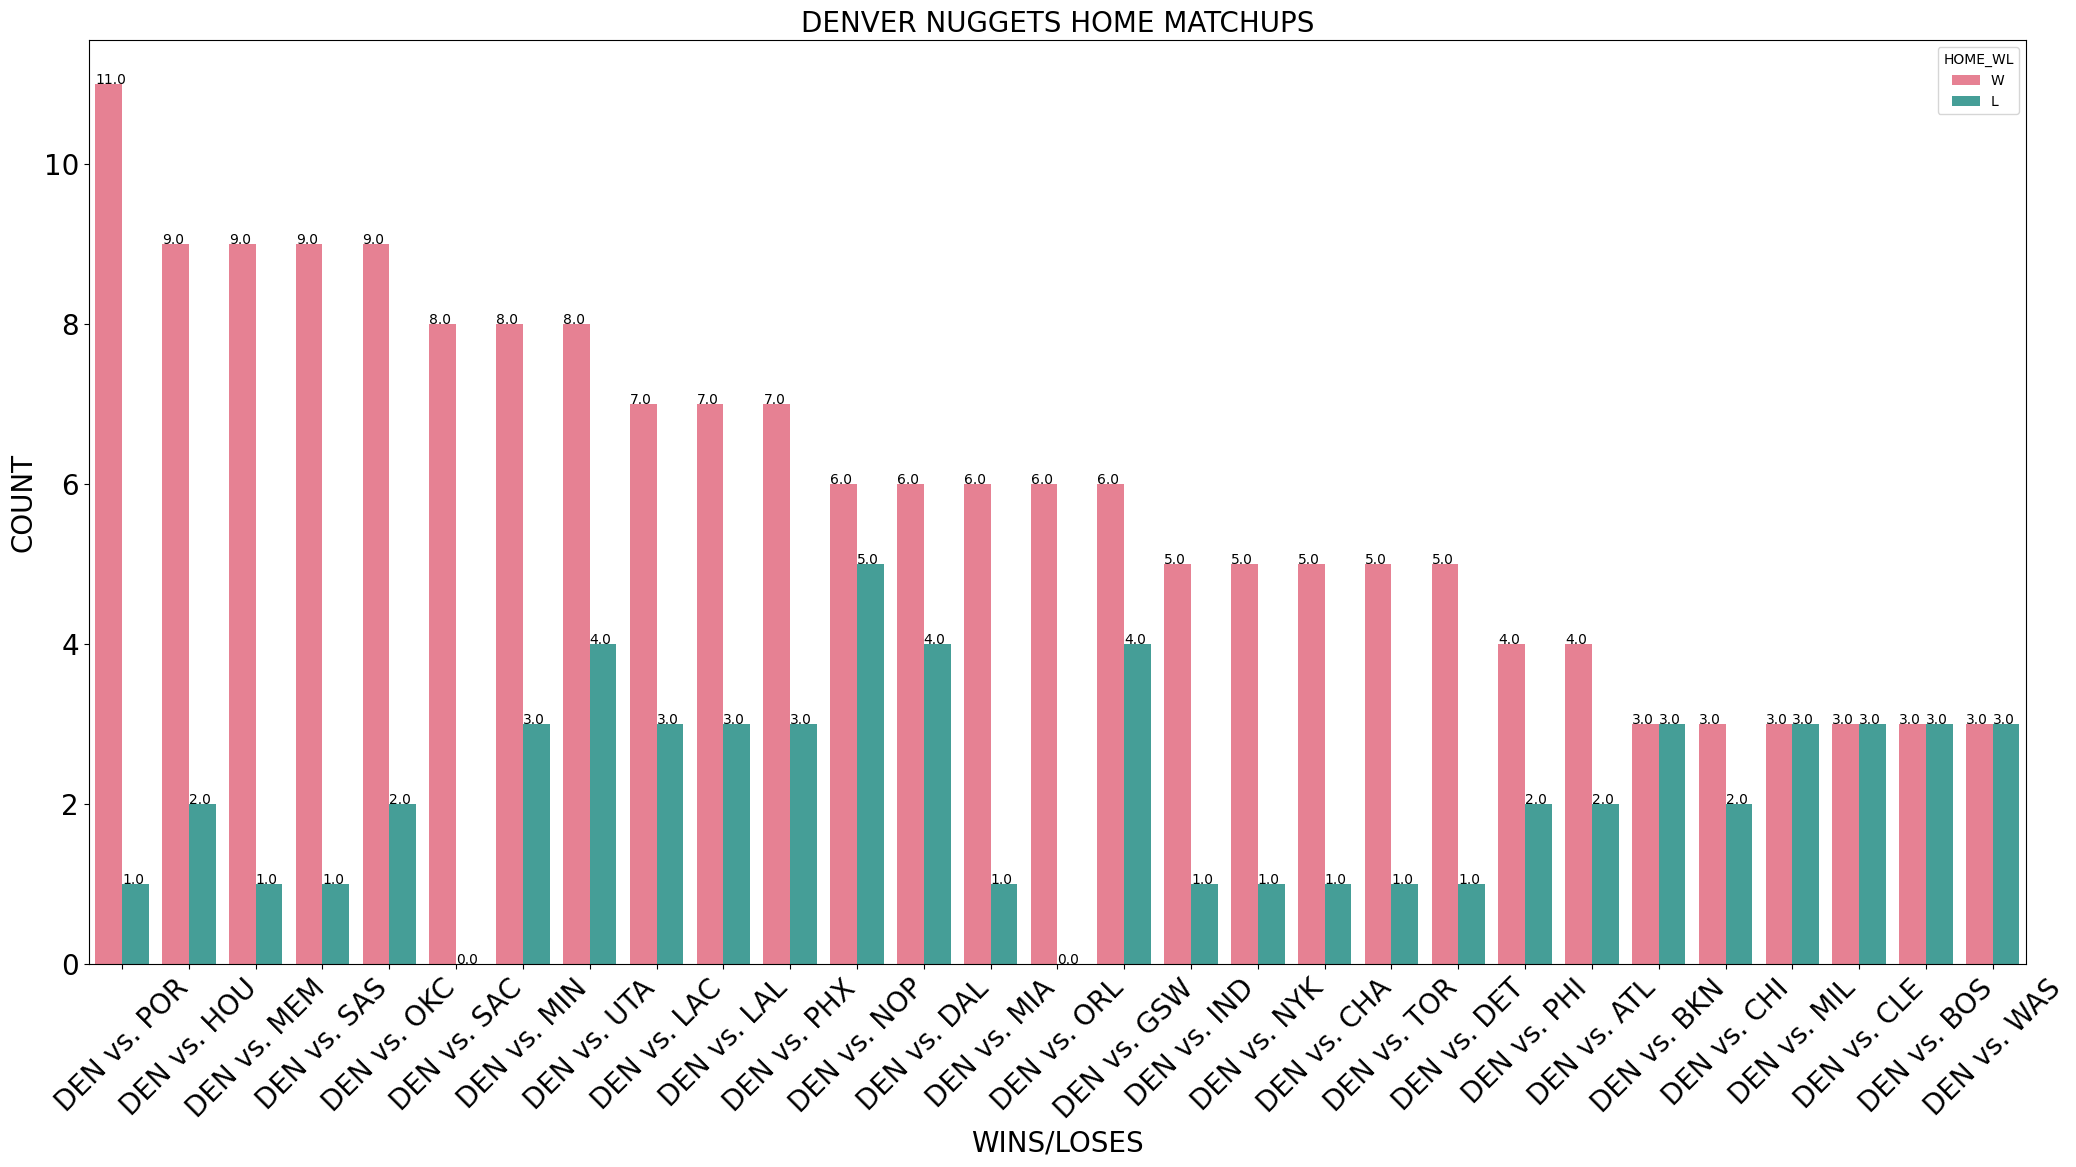

In [735]:
# DENVER NUGGETS HOME MATCHUPS

plt.figure(figsize=(25,12))
fig3 = sns.countplot(data=den_home_data, x=den_home_data['HOME_MATCHUP'],
                        palette = 'husl', 
                        hue = den_home_data['HOME_WL'],
                        order=den_home_data[den_home_data['HOME_WL'] == 'W']['HOME_MATCHUP'].value_counts().index
                        )
fig3.set_xlabel('WINS/LOSES', fontsize=20)
fig3.set_ylabel('COUNT', fontsize=20)
fig3.tick_params(labelsize=20)
plt.title('DENVER NUGGETS HOME MATCHUPS', fontsize = 20)
for p in fig3.patches:
    txt = str(p.get_height().round(2))
    txt_x = p.get_x() 
    txt_y = p.get_height()
    fig3.text(txt_x,txt_y,txt)
plt.xticks(rotation=45)
plt.show()

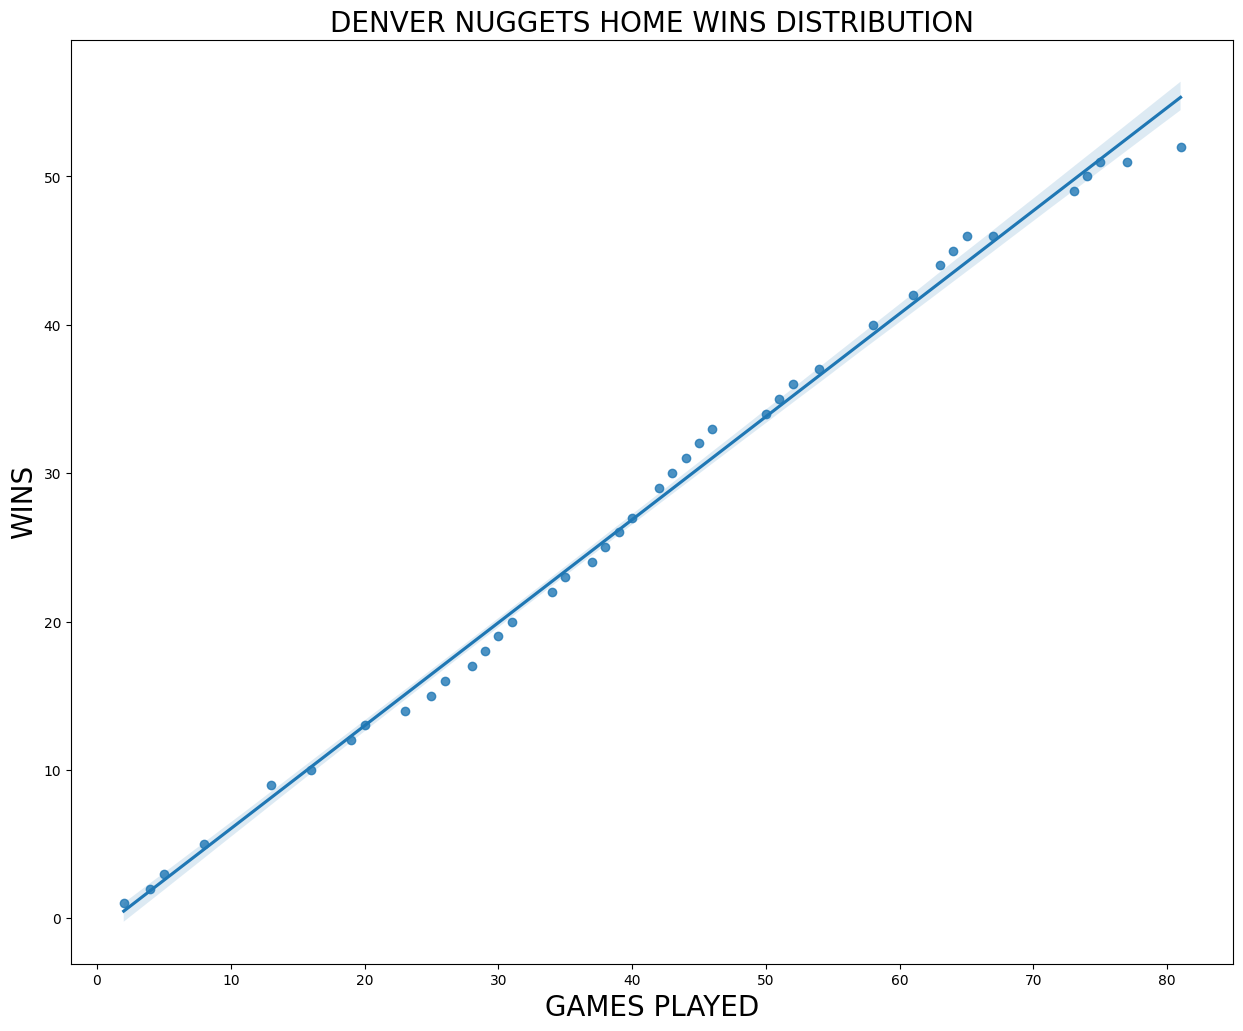

In [770]:
# DENVER NUGGETS WINS PER GAMES PLAYED

x = nba_data[(nba_data['HOME_TEAM_ABBREVIATION'] == 'DEN') & (nba_data['HOME_SEASON'] == '2022-23')]['GP_x']
y = nba_data[(nba_data['HOME_TEAM_ABBREVIATION'] == 'DEN') & (nba_data['HOME_SEASON'] == '2022-23')]['W_x']
x.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

plt.figure(figsize=(15,12))
fig4 = sns.regplot(
                    x=x,
                    y=y,
                    )
fig4.set_xlabel('GAMES PLAYED', fontsize=20)
fig4.set_ylabel('WINS', fontsize=20)
plt.title('DENVER NUGGETS HOME WINS DISTRIBUTION', fontsize = 20)
plt.show()

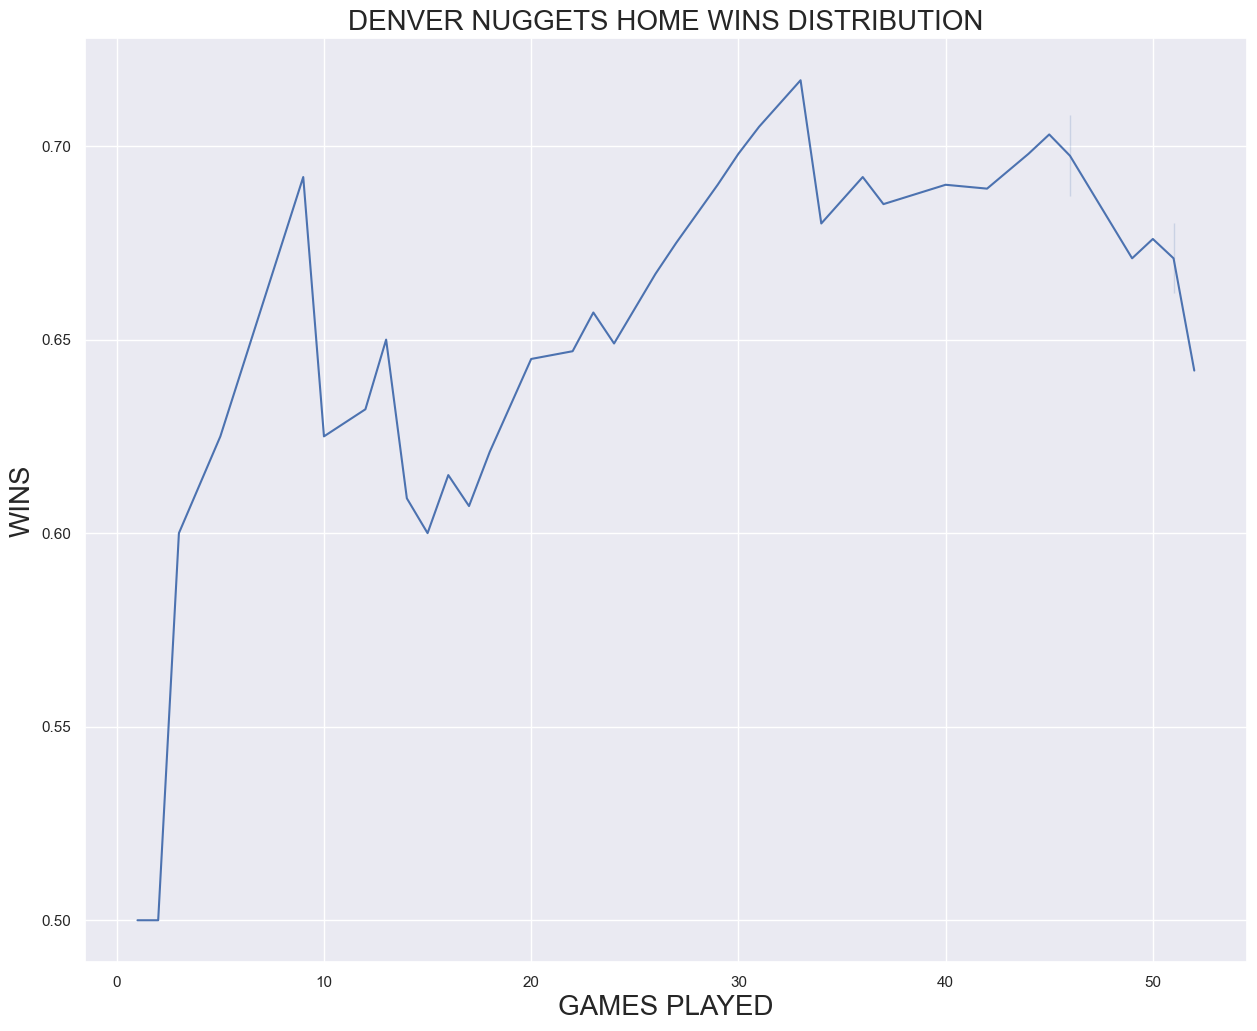

In [780]:
x = nba_data[(nba_data['HOME_TEAM_ABBREVIATION'] == 'DEN') & (nba_data['HOME_SEASON'] == '2022-23')]['W_PCT_x']
y = nba_data[(nba_data['HOME_TEAM_ABBREVIATION'] == 'DEN') & (nba_data['HOME_SEASON'] == '2022-23')]['W_x']
x.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

plt.figure(figsize=(15,12))
sns.set_theme(style="darkgrid")
fig4 = sns.lineplot(
                    x=y,
                    y=x,
                    )
fig4.set_xlabel('GAMES PLAYED', fontsize=20)
fig4.set_ylabel('WINS', fontsize=20)
plt.title('DENVER NUGGETS HOME WINS DISTRIBUTION', fontsize = 20)
plt.show()

In [723]:
det_home_data = nba_data[nba_data['HOME_TEAM_ABBREVIATION'] == 'DET']
det_home_data.head()

,Unnamed: 0,HOME_TEAM_ID,HOME_TEAM_ABBREVIATION,HOME_GAME_ID,HOME_MATCHUP,HOME_SEASON,HOME_GAME_N,HOME_WL,AWAY_TEAM_ID,AWAY_TEAM_ABBREVIATION,...,BLK_RANK_y,BLKA_RANK_y,PF_RANK_y,PFD_RANK_y,PTS_RANK_y,PLUS_MINUS_RANK_y,GAME_DATE_y,SEASON_y,GAME_N_y,COMPARE_y
63,63,1610612765,DET,22200769,DET vs. WAS,2022-23,66,L,1610612764,WAS,...,8,17,5,24,19,20,2023-03-05-2022_23,2022-23,65,65-1610612764-2022-23
105,105,1610612765,DET,22100368,DET vs. WAS,2021-22,24,L,1610612764,WAS,...,11,8,9,9,21,21,2021-12-06-2021_22,2021-22,26,26-1610612764-2021-22
152,152,1610612765,DET,22101101,DET vs. WAS,2021-22,74,L,1610612764,WAS,...,11,6,10,7,22,24,2022-03-24-2021_22,2021-22,73,73-1610612764-2021-22
207,207,1610612765,DET,22000179,DET vs. WAS,2020-21,48,W,1610612764,WAS,...,30,14,30,1,9,25,2021-03-30-2020_21,2020-21,47,47-1610612764-2020-21
256,256,1610612765,DET,21900394,DET vs. WAS,2019-20,27,L,1610612764,WAS,...,29,24,21,19,4,23,2019-12-14-2019_20,2019-20,25,25-1610612764-2019-20


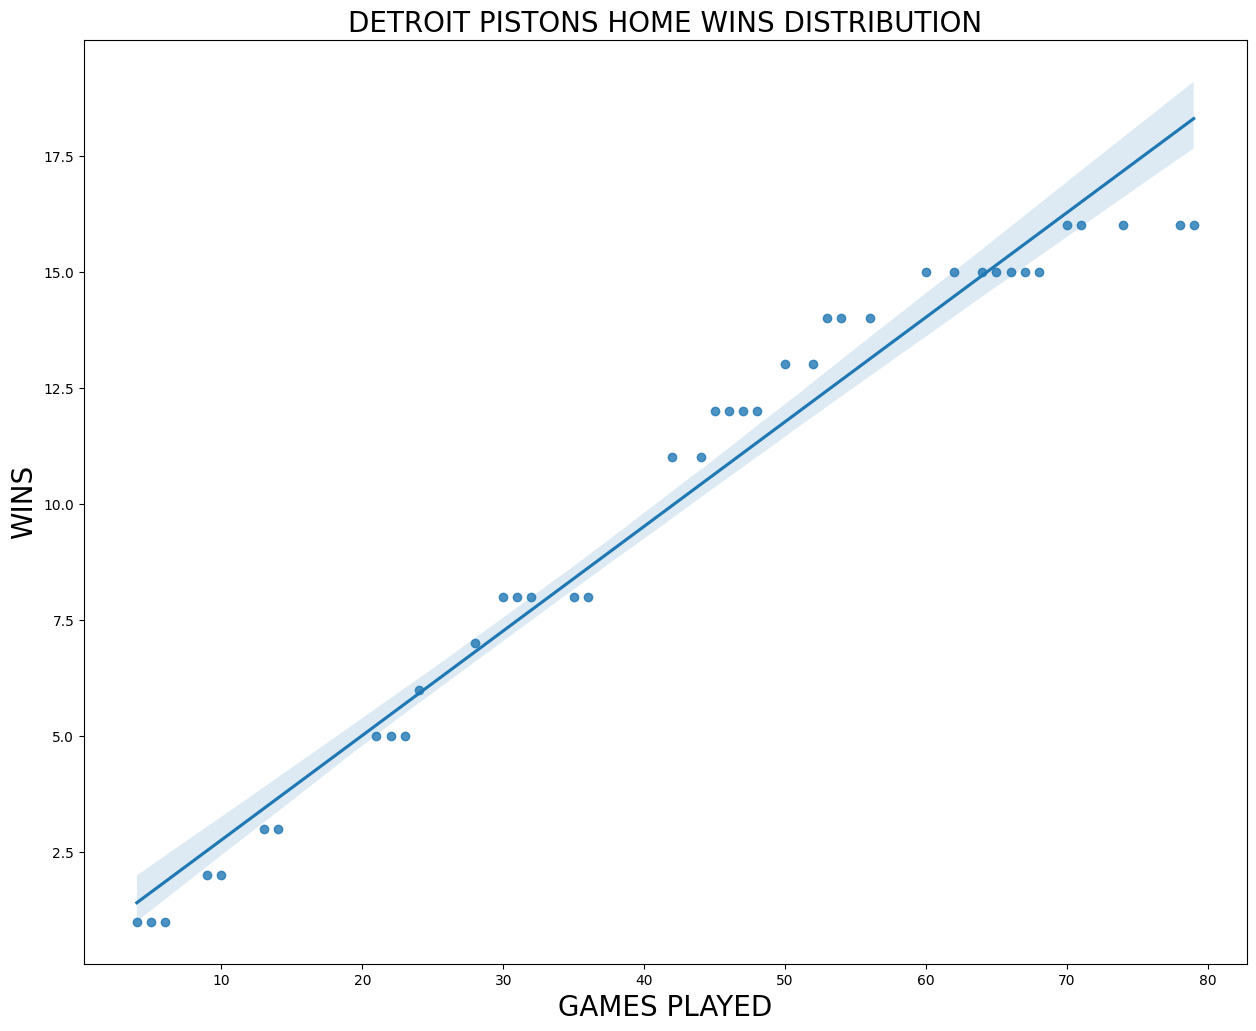

In [772]:
# DETROIT PISTONS WINS PER GAMES PLAYED

x = nba_data[(nba_data['HOME_TEAM_ABBREVIATION'] == 'DET') & (nba_data['HOME_SEASON'] == '2022-23')]['GP_x']
y = nba_data[(nba_data['HOME_TEAM_ABBREVIATION'] == 'DET') & (nba_data['HOME_SEASON'] == '2022-23')]['W_x']
x.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

plt.figure(figsize=(15,12))
fig5 = sns.regplot(
                    x=x,
                    y=y,
                    )
fig5.set_xlabel('GAMES PLAYED', fontsize=20)
fig5.set_ylabel('WINS', fontsize=20)
plt.title('DETROIT PISTONS HOME WINS DISTRIBUTION', fontsize = 20)
plt.show()

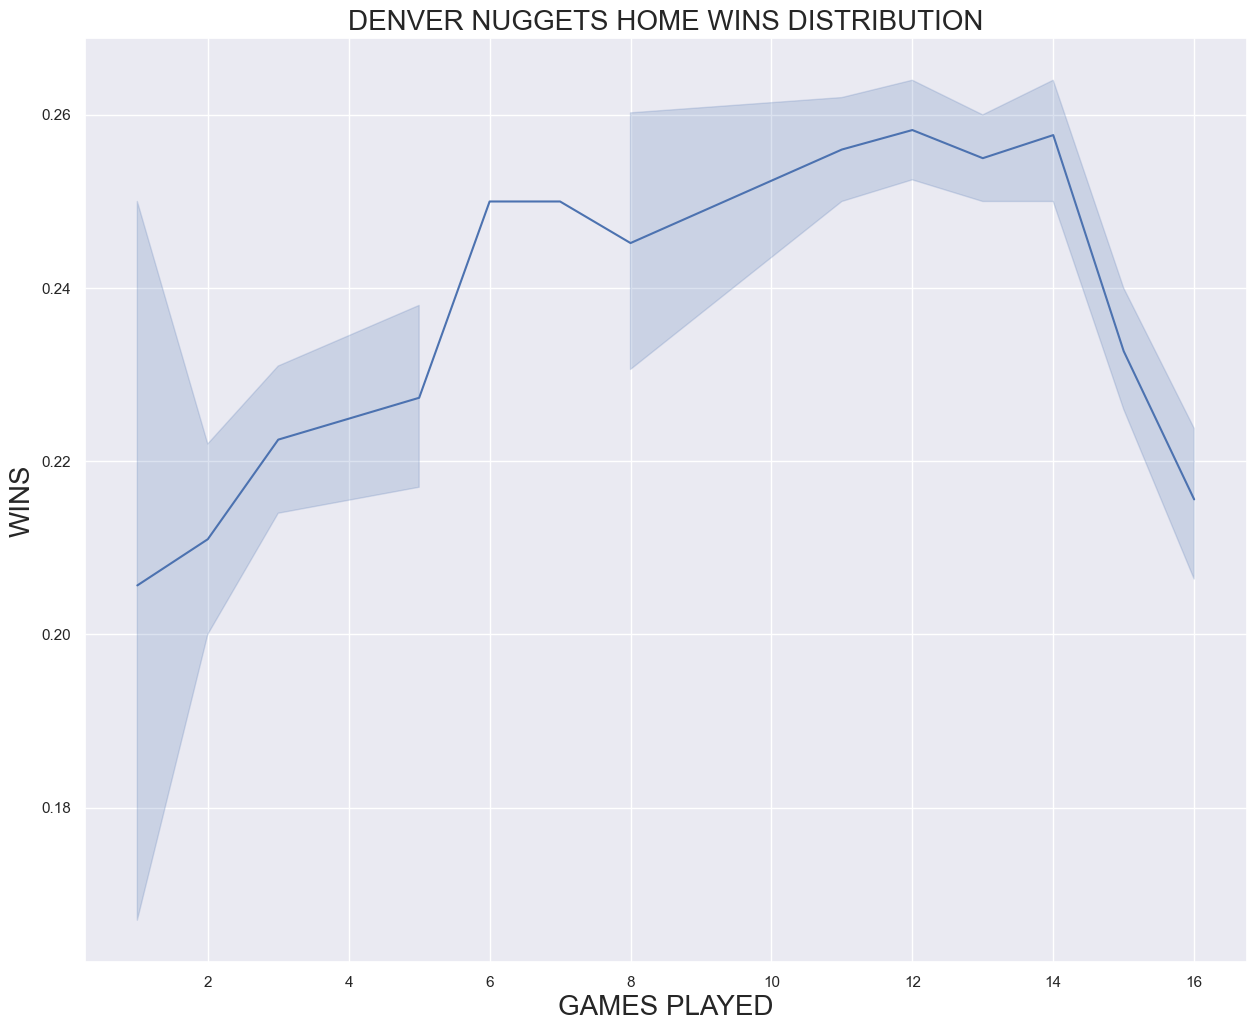

In [781]:
x = nba_data[(nba_data['HOME_TEAM_ABBREVIATION'] == 'DET') & (nba_data['HOME_SEASON'] == '2022-23')]['W_PCT_x']
y = nba_data[(nba_data['HOME_TEAM_ABBREVIATION'] == 'DET') & (nba_data['HOME_SEASON'] == '2022-23')]['W_x']
x.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

plt.figure(figsize=(15,12))
sns.set_theme(style="darkgrid")
fig4 = sns.lineplot(
                    x=y,
                    y=x,
                    )
fig4.set_xlabel('GAMES PLAYED', fontsize=20)
fig4.set_ylabel('WINS', fontsize=20)
plt.title('DENVER NUGGETS HOME WINS DISTRIBUTION', fontsize = 20)
plt.show()

# Previsão de resultados utilizando Redes Neurais

In [653]:
# Drop Columns

nba_data.drop(nba_data.columns[[0,1,2,3,4,5,7,8,9,10,11,12,13,14,
                                  15,16,17,70,71,72,73,74,75,128,129,130,131]], axis=1, inplace=True)

nba_data.to_excel('test_table.xlsx')

In [654]:
# Turn categorical column HOME_WL into numerial

nba_data['HOME_WL'] = nba_data['HOME_WL'].apply(lambda x: 0 if x == 'W' else 1)
nba_data.head()

,HOME_WL,GP_x,W_x,L_x,W_PCT_x,MIN_x,FGM_x,FGA_x,FG_PCT_x,FG3M_x,...,REB_RANK_y,AST_RANK_y,TOV_RANK_y,STL_RANK_y,BLK_RANK_y,BLKA_RANK_y,PF_RANK_y,PFD_RANK_y,PTS_RANK_y,PLUS_MINUS_RANK_y
0,0,1,1,0,1.000,48.0,42.0,92.0,0.457,11.0,...,12,15,14,2,6,2,25,8,8,7
1,0,2,1,1,0.500,48.0,43.0,81.0,0.531,13.0,...,10,17,24,21,2,7,7,27,18,9
2,0,3,2,1,0.667,49.7,42.0,86.3,0.486,11.0,...,8,9,9,14,28,30,10,7,17,27
3,1,4,3,1,0.750,49.3,42.5,86.0,0.494,10.8,...,9,7,16,26,3,21,23,17,11,25
4,0,5,3,2,0.600,49.0,41.6,86.0,0.484,15.2,...,24,14,23,21,5,7,19,23,20,11


In [655]:
# Separate database in train and test

X = nba_data.loc[:, nba_data.columns != 'HOME_WL']
y = nba_data['HOME_WL']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size= 0.3, 
                                                    random_state = 100, 
                                                    stratify = y,
                                                    )

In [656]:
# Check columns with variance equal to zero and drop them

zero_var_filter = VarianceThreshold()
X_train = zero_var_filter.fit_transform(X_train)
X_test = zero_var_filter.transform(X_test)
print('X_train e X_test possuíam', (zero_var_filter.variances_ == 0).sum(), 'atributo(s) com variância igual a zero \n')

print(zero_var_filter.variances_ == 0, '\n')

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train e X_test possuíam 0 atributo(s) com variância igual a zero 

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False] 

X_train: (4874, 104)
X_test: (2089, 104)
y_train: (4874,)
y_test: (2089,)


In [657]:
# Normalize data

preprocessParams = preprocessing.StandardScaler().fit(X_train)
X_train_normalized = preprocessParams.transform(X_train)
X_test_normalized = preprocessParams.transform(X_test)

X_train_normalized

array([[-0.19390183, -0.51290067,  0.17945249, ..., -0.17228294,
        -0.60944706,  0.07584392],
       [-1.61094241, -1.43070805, -1.36273462, ...,  1.22296558,
         0.88705677,  1.1184542 ],
       [-1.21239975, -1.43070805, -0.66875042, ...,  0.06025848,
        -1.18502546, -1.19845753],
       ...,
       [ 0.95744365,  0.94029435,  0.71921797, ..., -1.21871934,
        -1.06990978,  1.00260862],
       [ 0.69174854,  1.47568199, -0.28320365, ...,  0.87415345,
         1.46263517,  0.53922627],
       [-1.38952982, -1.12477225, -1.28562526, ..., -1.21871934,
         0.19636269, -1.31430312]])

In [658]:
# Train Neural Network

NumberOfClasses = len(y_train.unique())
NumberOfClasses

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
print(y_train)

[0 0 0 ... 1 0 1]


In [659]:
# Neural Network

RN = Sequential()
RN.add(Dense(25,input_shape = X_train_normalized.shape[1:],activation = 'sigmoid'))
RN.add(Dense(12,activation = 'sigmoid'))
RN.add(Dense(5,activation = 'sigmoid'))
RN.add(Dense(NumberOfClasses,activation = 'sigmoid'))
RN.summary()

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_158 (Dense)           (None, 25)                2625      
                                                                 
 dense_159 (Dense)           (None, 12)                312       
                                                                 
 dense_160 (Dense)           (None, 5)                 65        
                                                                 
 dense_161 (Dense)           (None, 2)                 12        
                                                                 
Total params: 3014 (11.77 KB)
Trainable params: 3014 (11.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [660]:
# Training

accuracy_threshold = 0.65

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs={}) :
        if(logs.get('accuracy') is not None and logs.get('accuracy') >= accuracy_threshold) :
            print('\nReached 65.0% accuracy.')
            self.model.stop_training = True

callbacks = myCallback()

RN.compile(optimizer = 'sgd', loss = 'binary_crossentropy', metrics = ['accuracy']) 
history = RN.fit(X_train_normalized, to_categorical(y_train), epochs = 600, 
                    batch_size=32, validation_split=0.3, callbacks = [callbacks])

Epoch 1/600
107/107 [==============================] - 1s 3ms/step - loss: 0.7875 - accuracy: 0.4298 - val_loss: 0.7464 - val_accuracy: 0.4463
Epoch 2/600
107/107 [==============================] - 0s 2ms/step - loss: 0.7335 - accuracy: 0.4298 - val_loss: 0.7135 - val_accuracy: 0.4463
Epoch 3/600
107/107 [==============================] - 0s 2ms/step - loss: 0.7074 - accuracy: 0.4298 - val_loss: 0.6986 - val_accuracy: 0.4463
Epoch 4/600
107/107 [==============================] - 0s 2ms/step - loss: 0.6949 - accuracy: 0.4752 - val_loss: 0.6918 - val_accuracy: 0.5427
Epoch 5/600
107/107 [==============================] - 0s 1ms/step - loss: 0.6887 - accuracy: 0.5641 - val_loss: 0.6888 - val_accuracy: 0.5537
Epoch 6/600
107/107 [==============================] - 0s 2ms/step - loss: 0.6857 - accuracy: 0.5702 - val_loss: 0.6876 - val_accuracy: 0.5537
Epoch 7/600
107/107 [==============================] - 0s 2ms/step - loss: 0.6842 - accuracy: 0.5702 - val_loss: 0.6871 - val_accuracy: 0.5537

In [661]:
# Evaluation

score = RN.evaluate(X_test_normalized, to_categorical(y_test), verbose = 0)
print('Test loss score:', score[0])
print('Test accuracy:', score[1])

Test loss score: 0.638097882270813
Test accuracy: 0.643848717212677


In [662]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


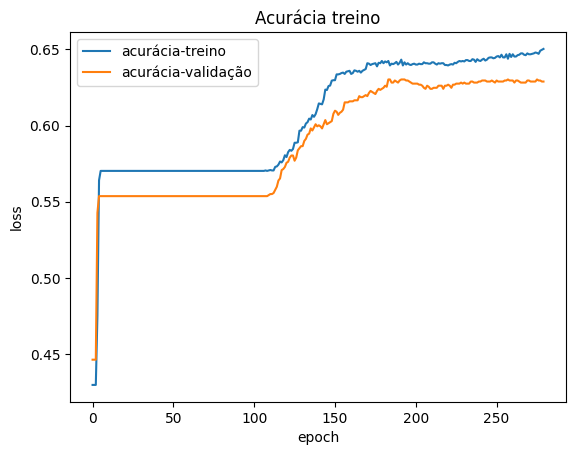

In [663]:
# Training chart: Training and validation per loss and epochs

#plt.plot(history.history['loss'], label='perda-treino')
#plt.plot(history.history['val_loss'], label='validação')
plt.plot(history.history['accuracy'], label='acurácia-treino')
plt.plot(history.history['val_accuracy'], label='acurácia-validação')
plt.title('Acurácia treino')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()